In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools
from biodatatools.utils.common import json_load, json_dump
import itertools
from Bio import SeqIO
from biodata.delimited import DelimitedReader, DelimitedWriter
import subprocess
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# CTCF binding

In [4]:
s = "HCT116"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]
t = "minTSS"
labels = ["Up", "Unchanged"]

In [5]:
# Criteria for elements with CTCF binding
# 1. CTCF motif prediction (FIMO)
# 2. CTCF ChIP-seq (1-bp overlap)

## Motif prediction

In [5]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [6]:
def get_sequence_for_prediction(inputfiles, fdict, outputfile):
	with DelimitedWriter(outputfile) as dw:
		for inputfile in inputfiles:
			with DelimitedReader(inputfile) as dr:
				for cols in dr:
					chrom, start, end = cols[:3]
					dw.write([">" + "_".join([chrom, start, end])])
					seq = fdict[chrom][int(start):int(end)].seq.upper()
					dw.write([seq])

In [7]:
inputfiles = [f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed" for g in gs]
outputfile = f"{PROJECT_DIR_o}FIMO/{s}_seqs.fa"
get_sequence_for_prediction(inputfiles, fdict, outputfile)

In [8]:
def get_motifs(motif_file, seq_file, outputfile):
	commands = [f"{PROJECT_DIR_s}meme-5.5.7/src/fimo", 
				 "--skip-matched-sequence",
				 "--verbosity 1",
				 motif_file, 
				 seq_file,
				 ">", outputfile
				 ]
	subprocess.run(" ".join(commands), shell=True)

In [9]:
# By default the program reports all motif occurrences with a p-value less than 1e-4. 

motif_file = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_CTCF.txt"
seq_file = f"{PROJECT_DIR_o}FIMO/{s}_seqs.fa"
outputfile = f"{PROJECT_DIR_o}FIMO/{s}_predictions.txt"
get_motifs(motif_file, seq_file, outputfile)

In [10]:
# https://meme-suite.org/meme/doc/fimo-output-format.html#tsv_results
# start: 1-based, included
# stop: 1-based, included

inputfile = f"{PROJECT_DIR_o}FIMO/{s}_predictions.txt"
df_fimo = pd.read_table(inputfile)
df_fimo.head(2)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MA0139.2,CTCF,chr1_998781_999282,63,77,-,9.18033,0.000068,NaN,NaN
1,MA0139.2,CTCF,chr1_998781_999282,405,419,+,10.21310,0.000043,NaN,NaN


In [11]:
# For each element, keep the motif with the smallest p-value

motifs = {}
for e, group in df_fimo.groupby("sequence_name"):
	top_row = group.sort_values(by="p-value").iloc[0]
	start = int(e.split("_")[1])
	mstart, mend = int(top_row["start"]), int(top_row["stop"])
	# motif center (0-based), start (0-based, included), end (0-based, not included)
	motifs[e] = [start + (mstart + mend) // 2 - 1, start + mstart - 1, start + mend, top_row["strand"]]

## ChIP-seq

In [12]:
binding_labels = {}
b1 = pybedtools.BedTool(f"{PROJECT_DIR_r}ENCODE/ENCFF832INR.bed.gz")
for g in gs:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed")
	overlaps = set(["_".join(i.fields[:3]) for i in b2.intersect(b1, u=True)])
	for i in b2:
		e = "_".join(i.fields[:3])
		# Motif + ChIP-seq
		binding_labels[e] = "CTCF binding" if e in overlaps & set(motifs.keys()) else "No CTCF binding"

In [13]:
json_dump(f"{PROJECT_DIR_o}labels/{s}_CTCF_ChIP.json", binding_labels)

In [14]:
motifs2 = {}
for e in motifs:
	if binding_labels[e] == "CTCF binding":
		motifs2[e] = motifs[e]
len(motifs2)

3518

In [15]:
json_dump(f"{PROJECT_DIR_o}FIMO/{s}_CTCF_pos.json", motifs2)

# %CTCF binding vs. DE

In [16]:
DE_labels = json_load(f"{PROJECT_DIR_o}labels/{s}_CTCF_DE.json")

In [17]:
es = {}
for g in gs:
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed")
	es[g] = ["_".join(i.fields[:3]) for i in b]

In [18]:
results = []
for g in gs:
	for e in es[g]:
		if e in DE_labels[t]:
			results.append([t, g, DE_labels[t][e], binding_labels[e]])
df_labels = pd.DataFrame(results, columns=["TSS", "Group", "DE_label", "CTCF_label"])

In [19]:
results = []
for g, label in itertools.product(gs, labels):
	tot = df_labels[(df_labels["TSS"]==t) & (df_labels["Group"]==g) & (df_labels["DE_label"]==label)]
	sub = tot[tot["CTCF_label"]=="CTCF binding"]
	prop = len(sub)/len(tot)*100
	p, d = g.split("_")
	results.append([d, p.capitalize(), t, label, len(tot), len(sub), prop])
df_ctcf_prop = pd.DataFrame(results, columns=["Group1", "Group2", "Side", "Label", "No. elements", "No. CTCF binding", "Proportion"])

In [20]:
def plot_props(df, outputfile):
	fig, ax = plt.subplots(figsize=(3,2.5))
	g = sns.barplot(data=df, x="Label", y="Proportion", hue="Group2", palette=["#807dba", "#fccde5"])
	g.spines[["right", "top"]].set_visible(False)
	g.legend(loc="upper left", bbox_to_anchor=(0.5,1), fontsize=sfontsize, frameon=False)
	
	texts = []
	for p in ps:
		for index, row in df[df["Group2"]==p.capitalize()].iterrows():
			texts.append(f"{row['No. CTCF binding']}/{row['No. elements']}")
	for bar, text in zip(g.patches, texts):
		g.text(bar.get_x()+0.15, 20, text, color="#000000", rotation=90, fontsize=sfontsize) 

	g.set_ylim([0,105])
	g.set_ylabel("CTCF-bound TREs (%)", fontsize=bfontsize)
	g.tick_params(axis="y", labelsize=sfontsize)

	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize)

	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

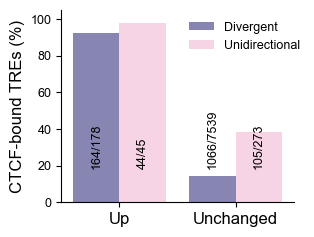

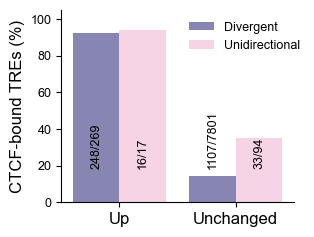

In [21]:
for d in ds:	
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8c.pdf"
	plot_props(df_ctcf_prop[(df_ctcf_prop["Group1"]==d)], outputfile)

# %Up vs. directionality

In [22]:
quantiles = json_load(f"{PROJECT_DIR_o}labels/{s}_DI.json")

In [23]:
results = []
for g in gs:
	for e in es[g]:
		if e in DE_labels[t]:
			l = "Uni" if "unidirectional" in g else quantiles[e]
			results.append([t, g.split("_")[1], DE_labels[t][e], l])
df_labels2 = pd.DataFrame(results, columns=["TSS", "Group", "DE_label", "DI_label"])

In [29]:
qs = ["Q1", "Q2", "Q3", "Q4", "Uni"]
results = []
for d, q in itertools.product(ds, qs):
	tot = df_labels2[(df_labels2["TSS"]==t) & (df_labels2["Group"]==d) & (df_labels2["DI_label"]==q)]
	sub = tot[tot["DE_label"]=="Up"]
	prop = len(sub)/len(tot)*100
	results.append([d, q, t, len(tot), len(sub), prop])
df_up_prop = pd.DataFrame(results, columns=["Group1", "Group2", "Side", "No. elements", "No. Ups", "Proportion"])
df_up_prop.head(2)

,Group1,Group2,Side,No. elements,No. Ups,Proportion
0,distal,Q1,minTSS,2080,12,0.576923
1,distal,Q2,minTSS,2035,29,1.425061


In [31]:
def plot_props2(d, df, outputfile):
	fig, ax = plt.subplots(figsize=(3,2.2))
	g = sns.barplot(data=df, x="Group2", y="Proportion", hue="Group2", legend=False,
					palette=["#9ecae1", "#4292c6", "#807dba", "#3f007d", "#fccde5"])
	g.spines[["right", "top"]].set_visible(False)
	
	texts = []
	for q in qs:
		row = df[df["Group2"] == q].iloc[0]
		texts.append(f"{row['No. Ups']}/{row['No. elements']}")

	for bar, text in zip(g.patches, texts):
		if texts.index(text) == 4:
			y = bar.get_height()-10
		else:
			y = bar.get_height()+2
		g.text(bar.get_x()+0.3, y, text, color="#000000", rotation=90, fontsize=sfontsize) 
		
	g.set_ylim([0,17])
	g.set_ylabel("Up (%)", fontsize=bfontsize)
	g.yaxis.set_label_coords(-0.15, 0.5)
	g.tick_params(axis="y", labelsize=sfontsize)

	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize)

	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

In [ ]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8e.pdf"
	plot_props2(d, df_up_prop[(df_up_prop["Group1"]==d)], outputfile)